    사용하고 있는 데이터 세트는 다양한 개체들의 여섯 가지 운동(아래로 내려가기, 조깅, 앉기, 서기, 위로 올라가기, 걷기)을 수행하는 동안 IMU 센서 및 휴대폰에서 수집한 가속도 데이터 모음입니다. 각 운동에 대해 x, y, z 축의 가속도를 측정하여 타임스탬프와 개체 ID와 함께 캡처되었습니다.
    
    이러한 데이터를 사용하여 신경망을 훈련하여 센서가 부착된 개체의 여섯 가지 활동 중 하나를 수행하고 있는지 해석합니다. 신경망이 기존 데이터로 훈련되면 이전에 보지 못한 데이터가 주어질 때 개체가 수행하고 있는 활동의 유형을 올바르게 예측할 수 있어야 합니다.
    
    사용 가능한 데이터를 기반으로 DL 모델은 여섯 가지 활동 중 각각을 구별하는 방법을 학습할 것입니다. 그런 다음 신경망에 새로운 데이터를 보여주면 특정 시점에 사용자가 무엇을 하고 있는지 알려줄 것입니다. 이 문제에 대한 해결책은 아래 그림에 나와 있습니다.

<img src ='pics/1.png'>

In [2]:
#from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

keras version  3.5.0


    TIME_PERIODS - time 세그먼트의 길이
    STEP_DISTANCE - 2개의 연속되는 time 세그먼트 사이의 오버랩 크기

In [5]:
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# 하나의 time 세그먼트내에서의 step의 개수
TIME_PERIODS = 80
# 다른 세그먼트로 가기 위한 step의 개수, 이 값이 TIME_PERIODS와 같아디면 세그먼트 사이의 오버랩이 없음.
STEP_DISTANCE = 40

### Data 로딩

In [6]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 칼럼에 불필요한 문자 제거
    df['z-axis'] = df['z-axis'].str.replace(';', '').astype(float)
    # df['z-axis'].replace(regex=True,
    #   inplace=True,
    #   to_replace=r';',
    #   value=r'')
    # ... and then this column must be transformed to float explicitly
    # df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    print('dataframe에서 열의 개수: %i' % (dataframe.shape[1]))
    print('dataframe에서 행의 개수: %i\n' % (dataframe.shape[0]))

In [8]:
# csv 파일 형태의 data 로딩
df = read_data('dataset/WISDM_ar_v1.1_raw.txt')

In [9]:
# dataframe 정보 출력
show_basic_dataframe_info(df)
df.head()

dataframe에서 열의 개수: 6
dataframe에서 행의 개수: 1086475



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [10]:
df.tail()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
1086471,19,Sitting,131623331483000,9.0,-1.6,1.7
1086472,19,Sitting,131623371431000,9.0,-1.5,1.7
1086473,19,Sitting,131623411592000,9.1,-1.4,1.7
1086474,19,Sitting,131623491487000,9.0,-1.5,1.7
1086475,19,Sitting,131623531465000,8.9,-1.3,1.6


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086475 entries, 0 to 1086475
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


### 실험 Data 분석

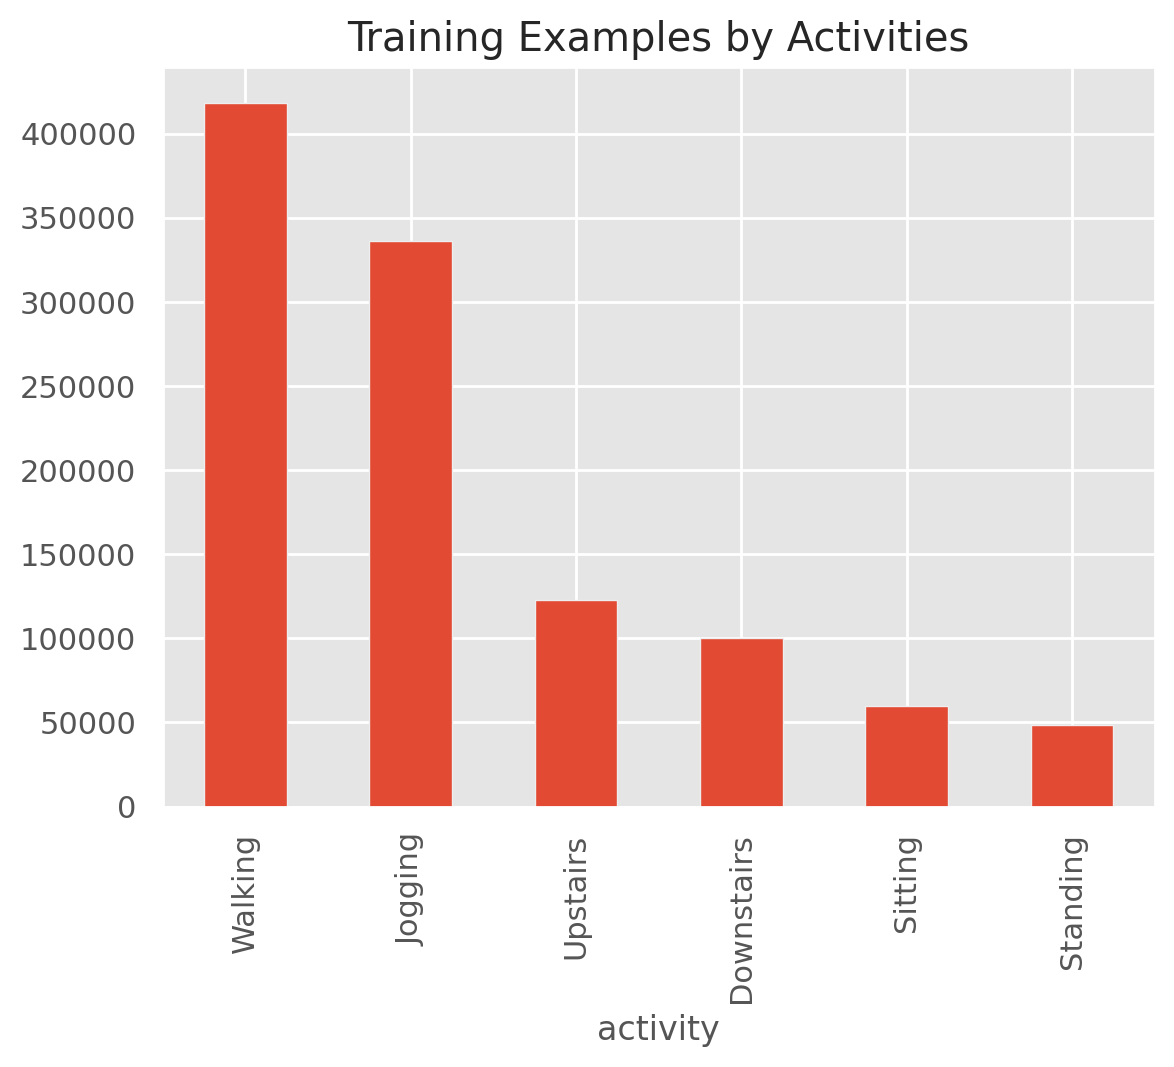

In [13]:
# 6가지 활동 각각에 대해서 얼마나 많은 training 예제가 있는지
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activities')
plt.show()

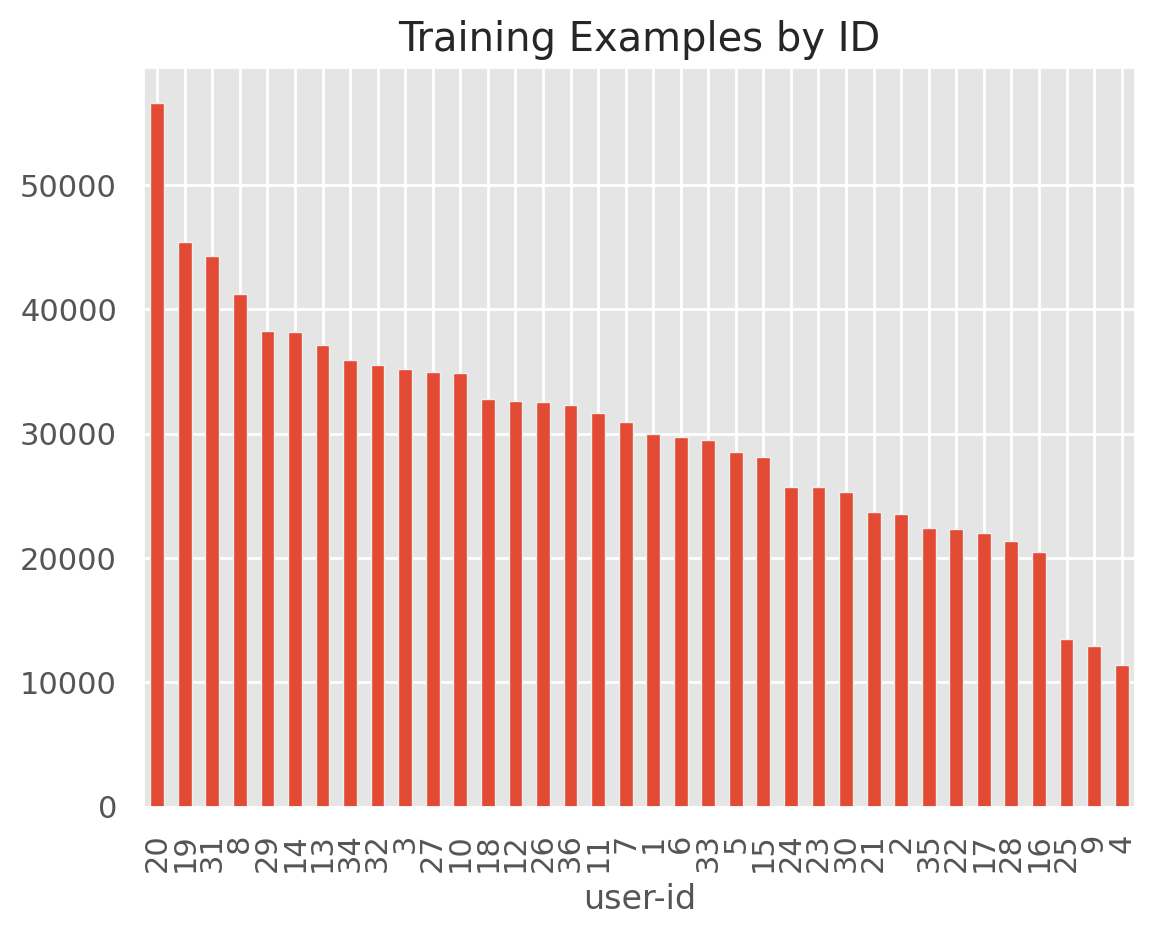

In [14]:
# 이 연구에 참여한 개체들 사이의 값이 어떻게 분포하는지를 더 잘 이해하기 위해
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by ID')
plt.show()

In [15]:
print(set(df['user-id']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [16]:
len(set(df['user-id']))

36

보시다시피, 다른 활동들에 비해 걷기와 뛰기 활동에 대한 데이터가 더 많습니다. 또한 36 개체가 실험에 참여했습니다.

### Data 시각화

다음으로, 세 가지 축에 대한 가속도 데이터를 여섯 가지 가능한 활동 모두에 대해 살펴보겠습니다. 데이터는 20Hz (초당 20개의 값)의 샘플링 속도로 기록됩니다. 처음 180개의 레코드를 표시하므로 각 차트는 여섯 가지 활동 각각에 대해 9초 간격을 보여줍니다 (계산: 0.05 * 180 = 9초).

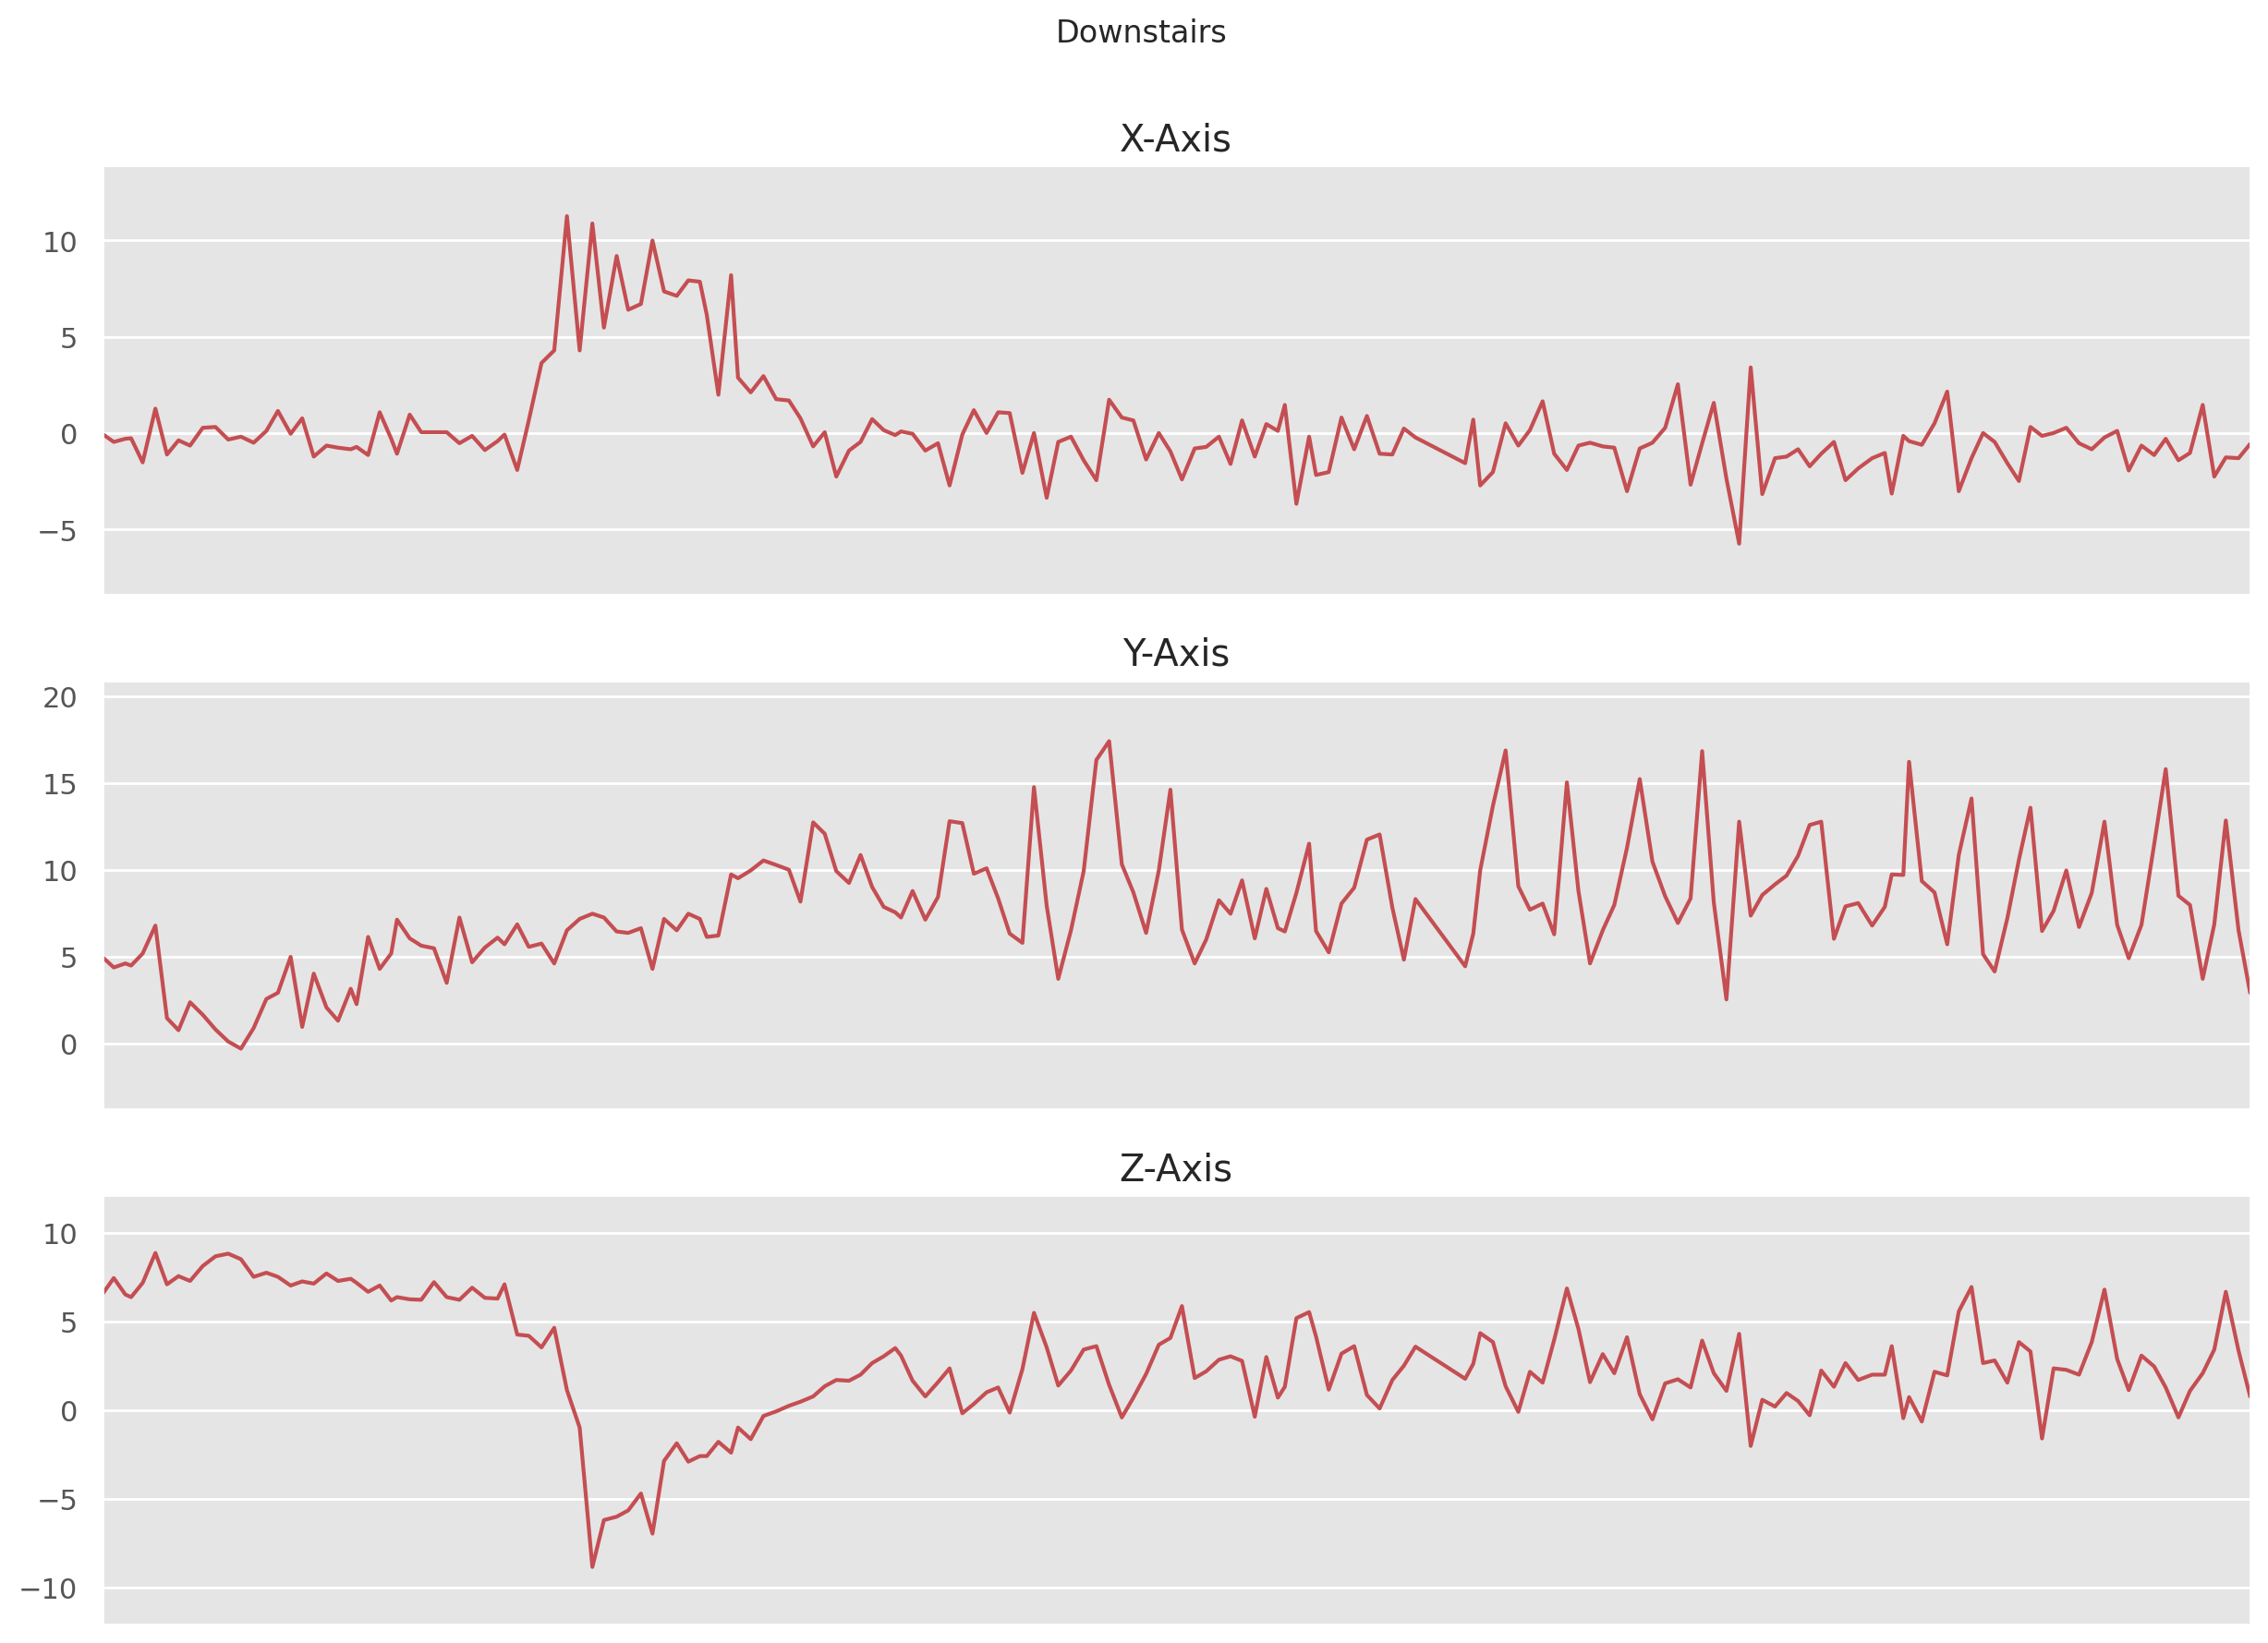

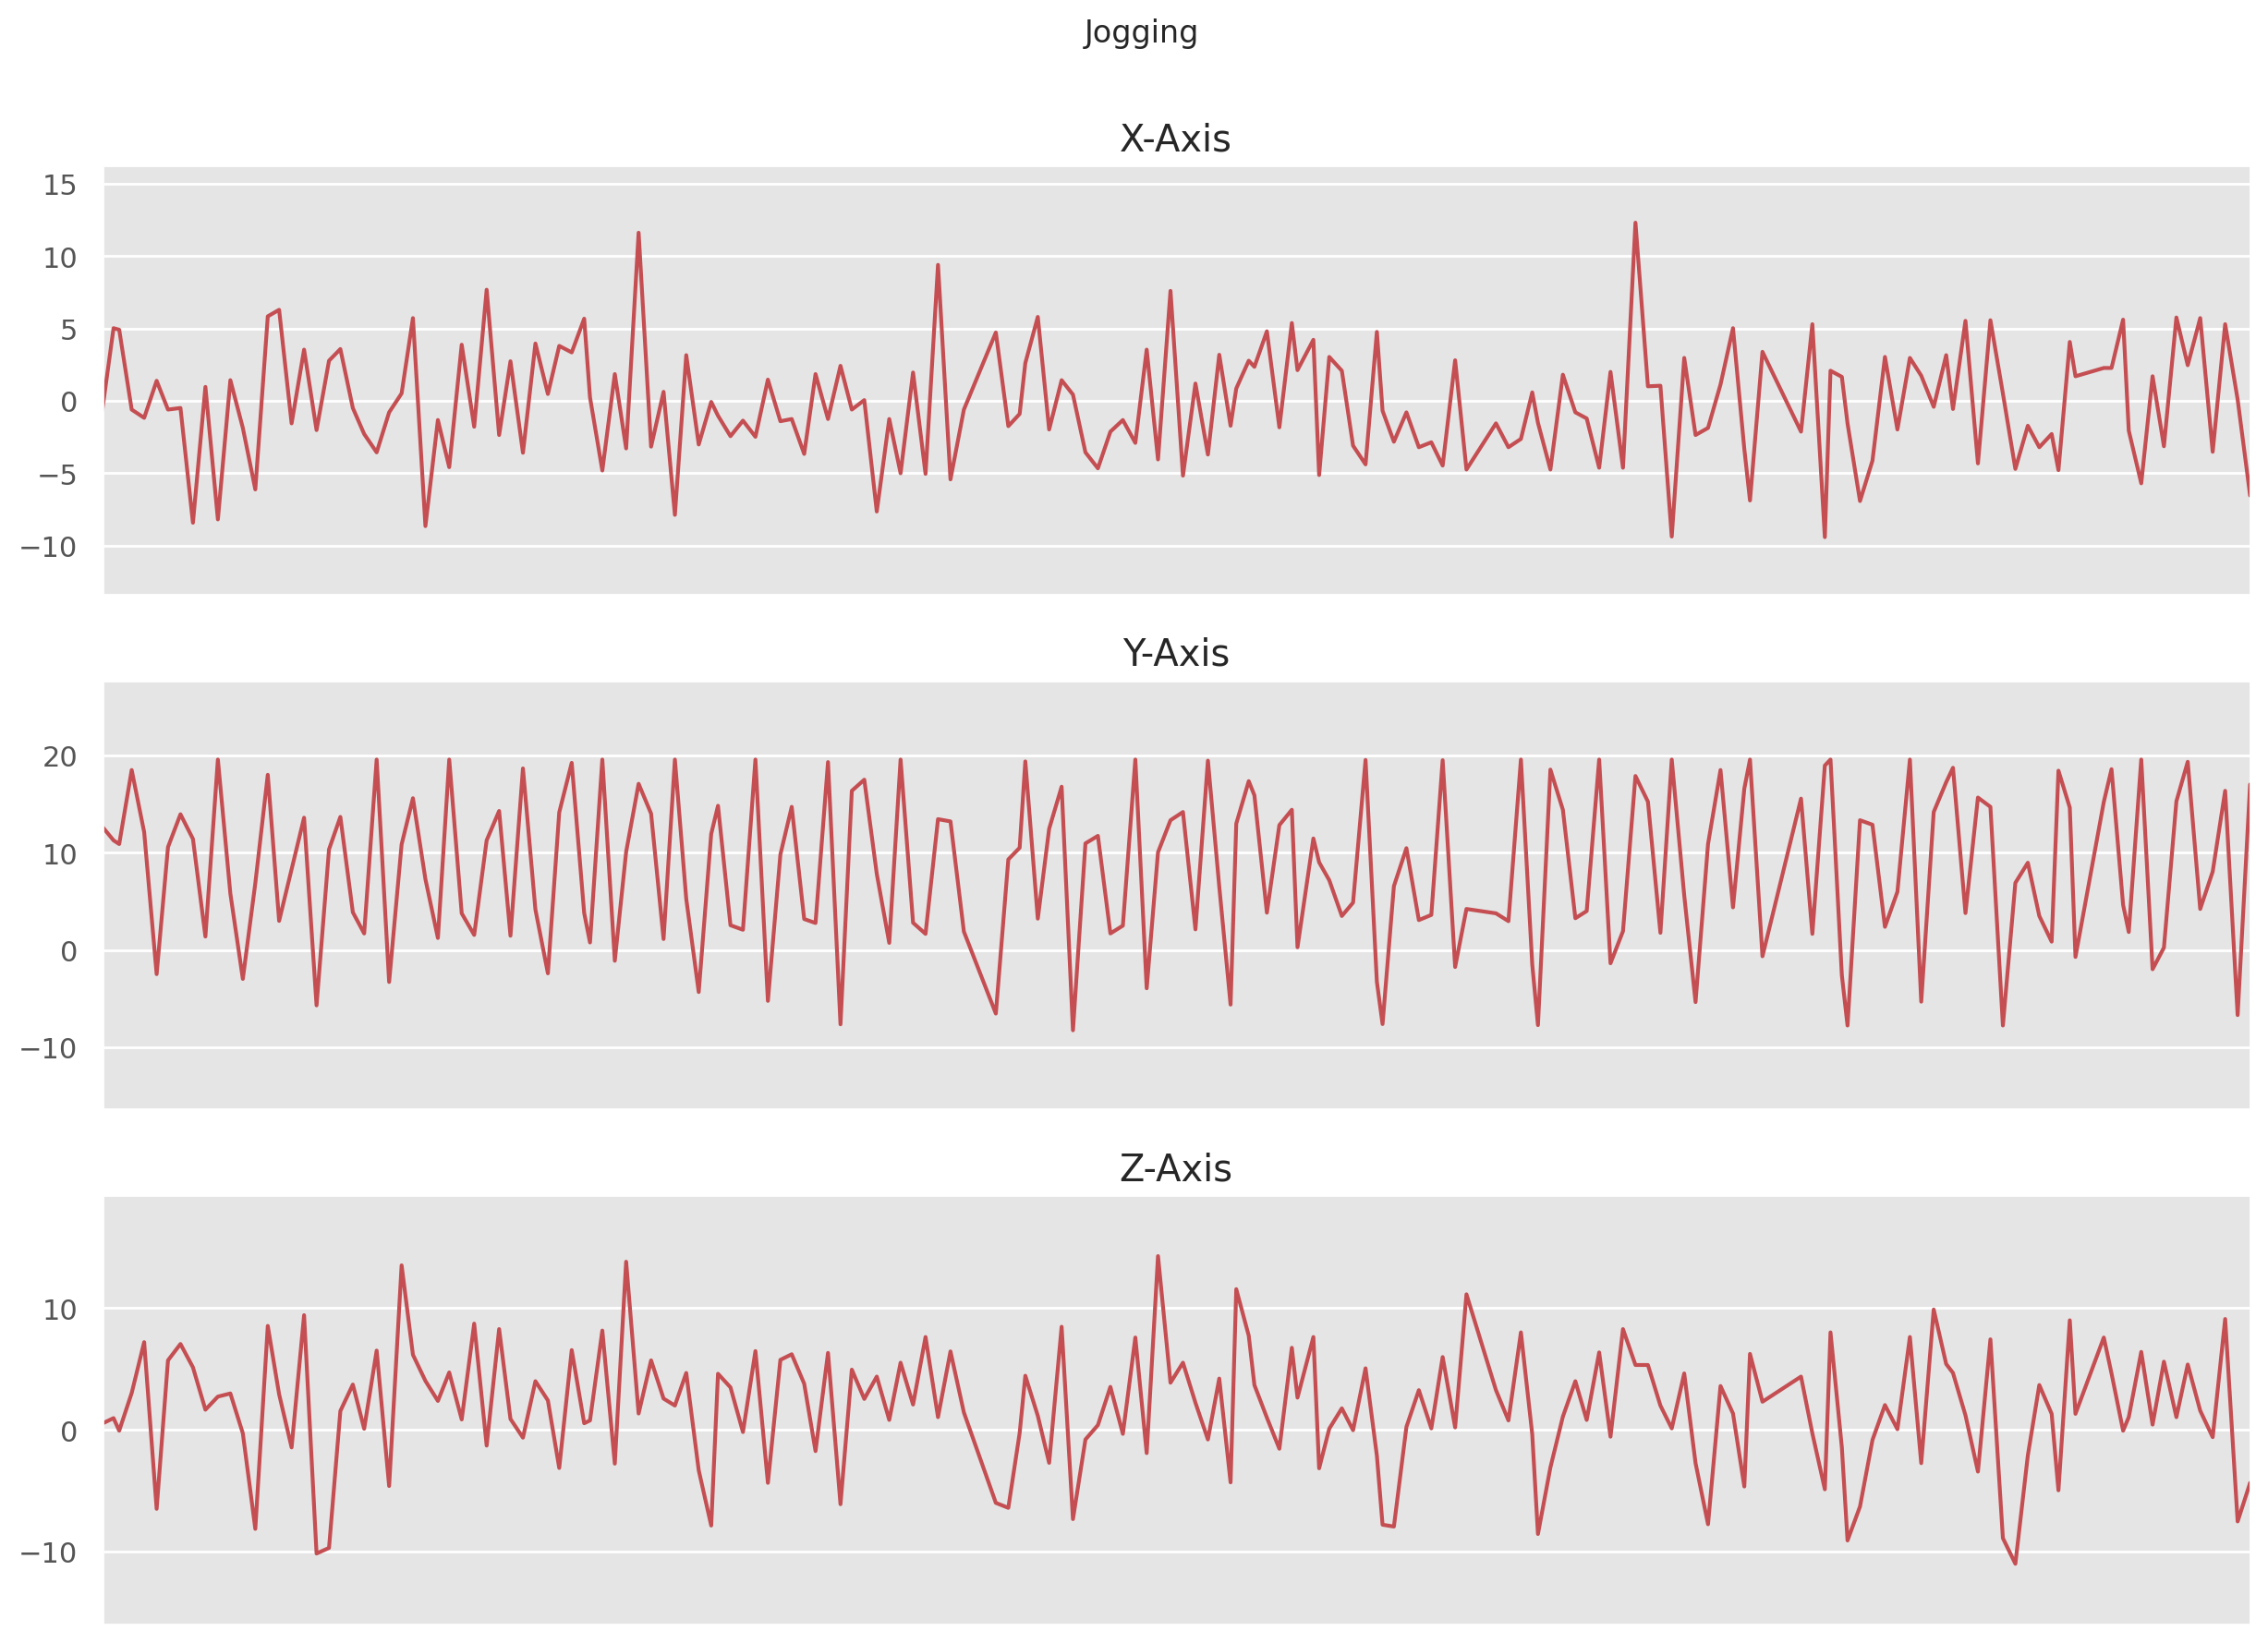

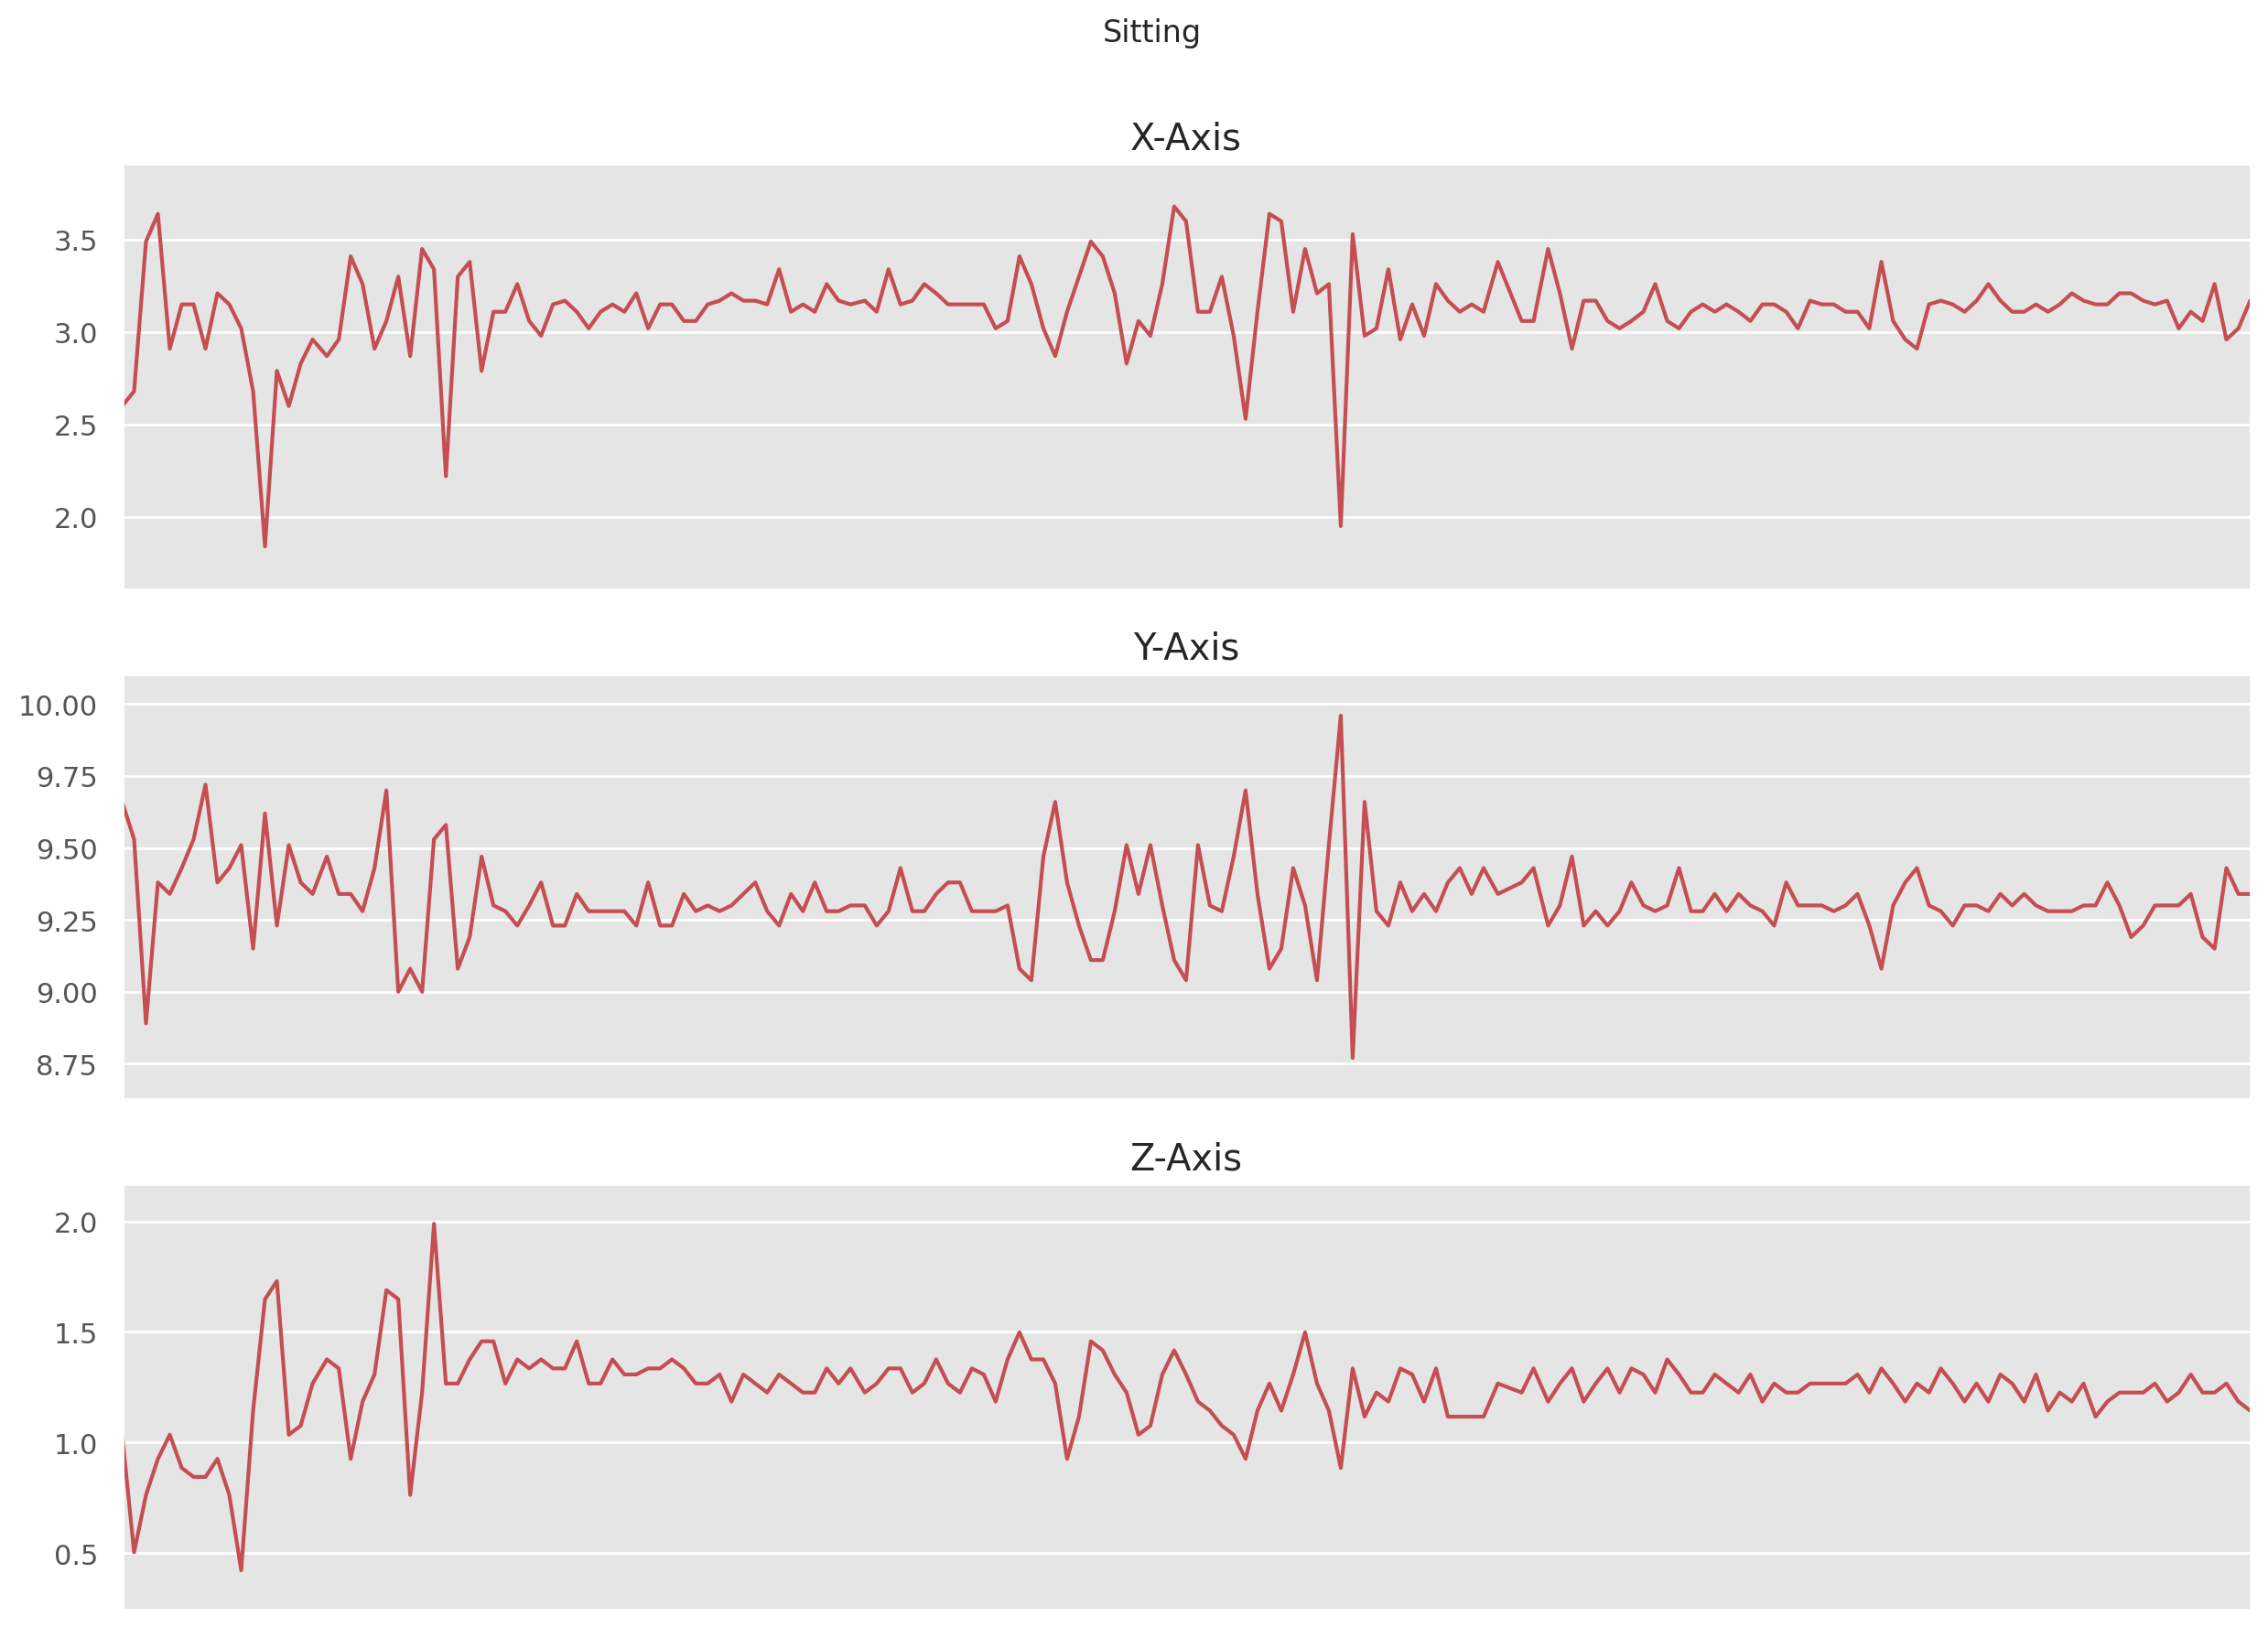

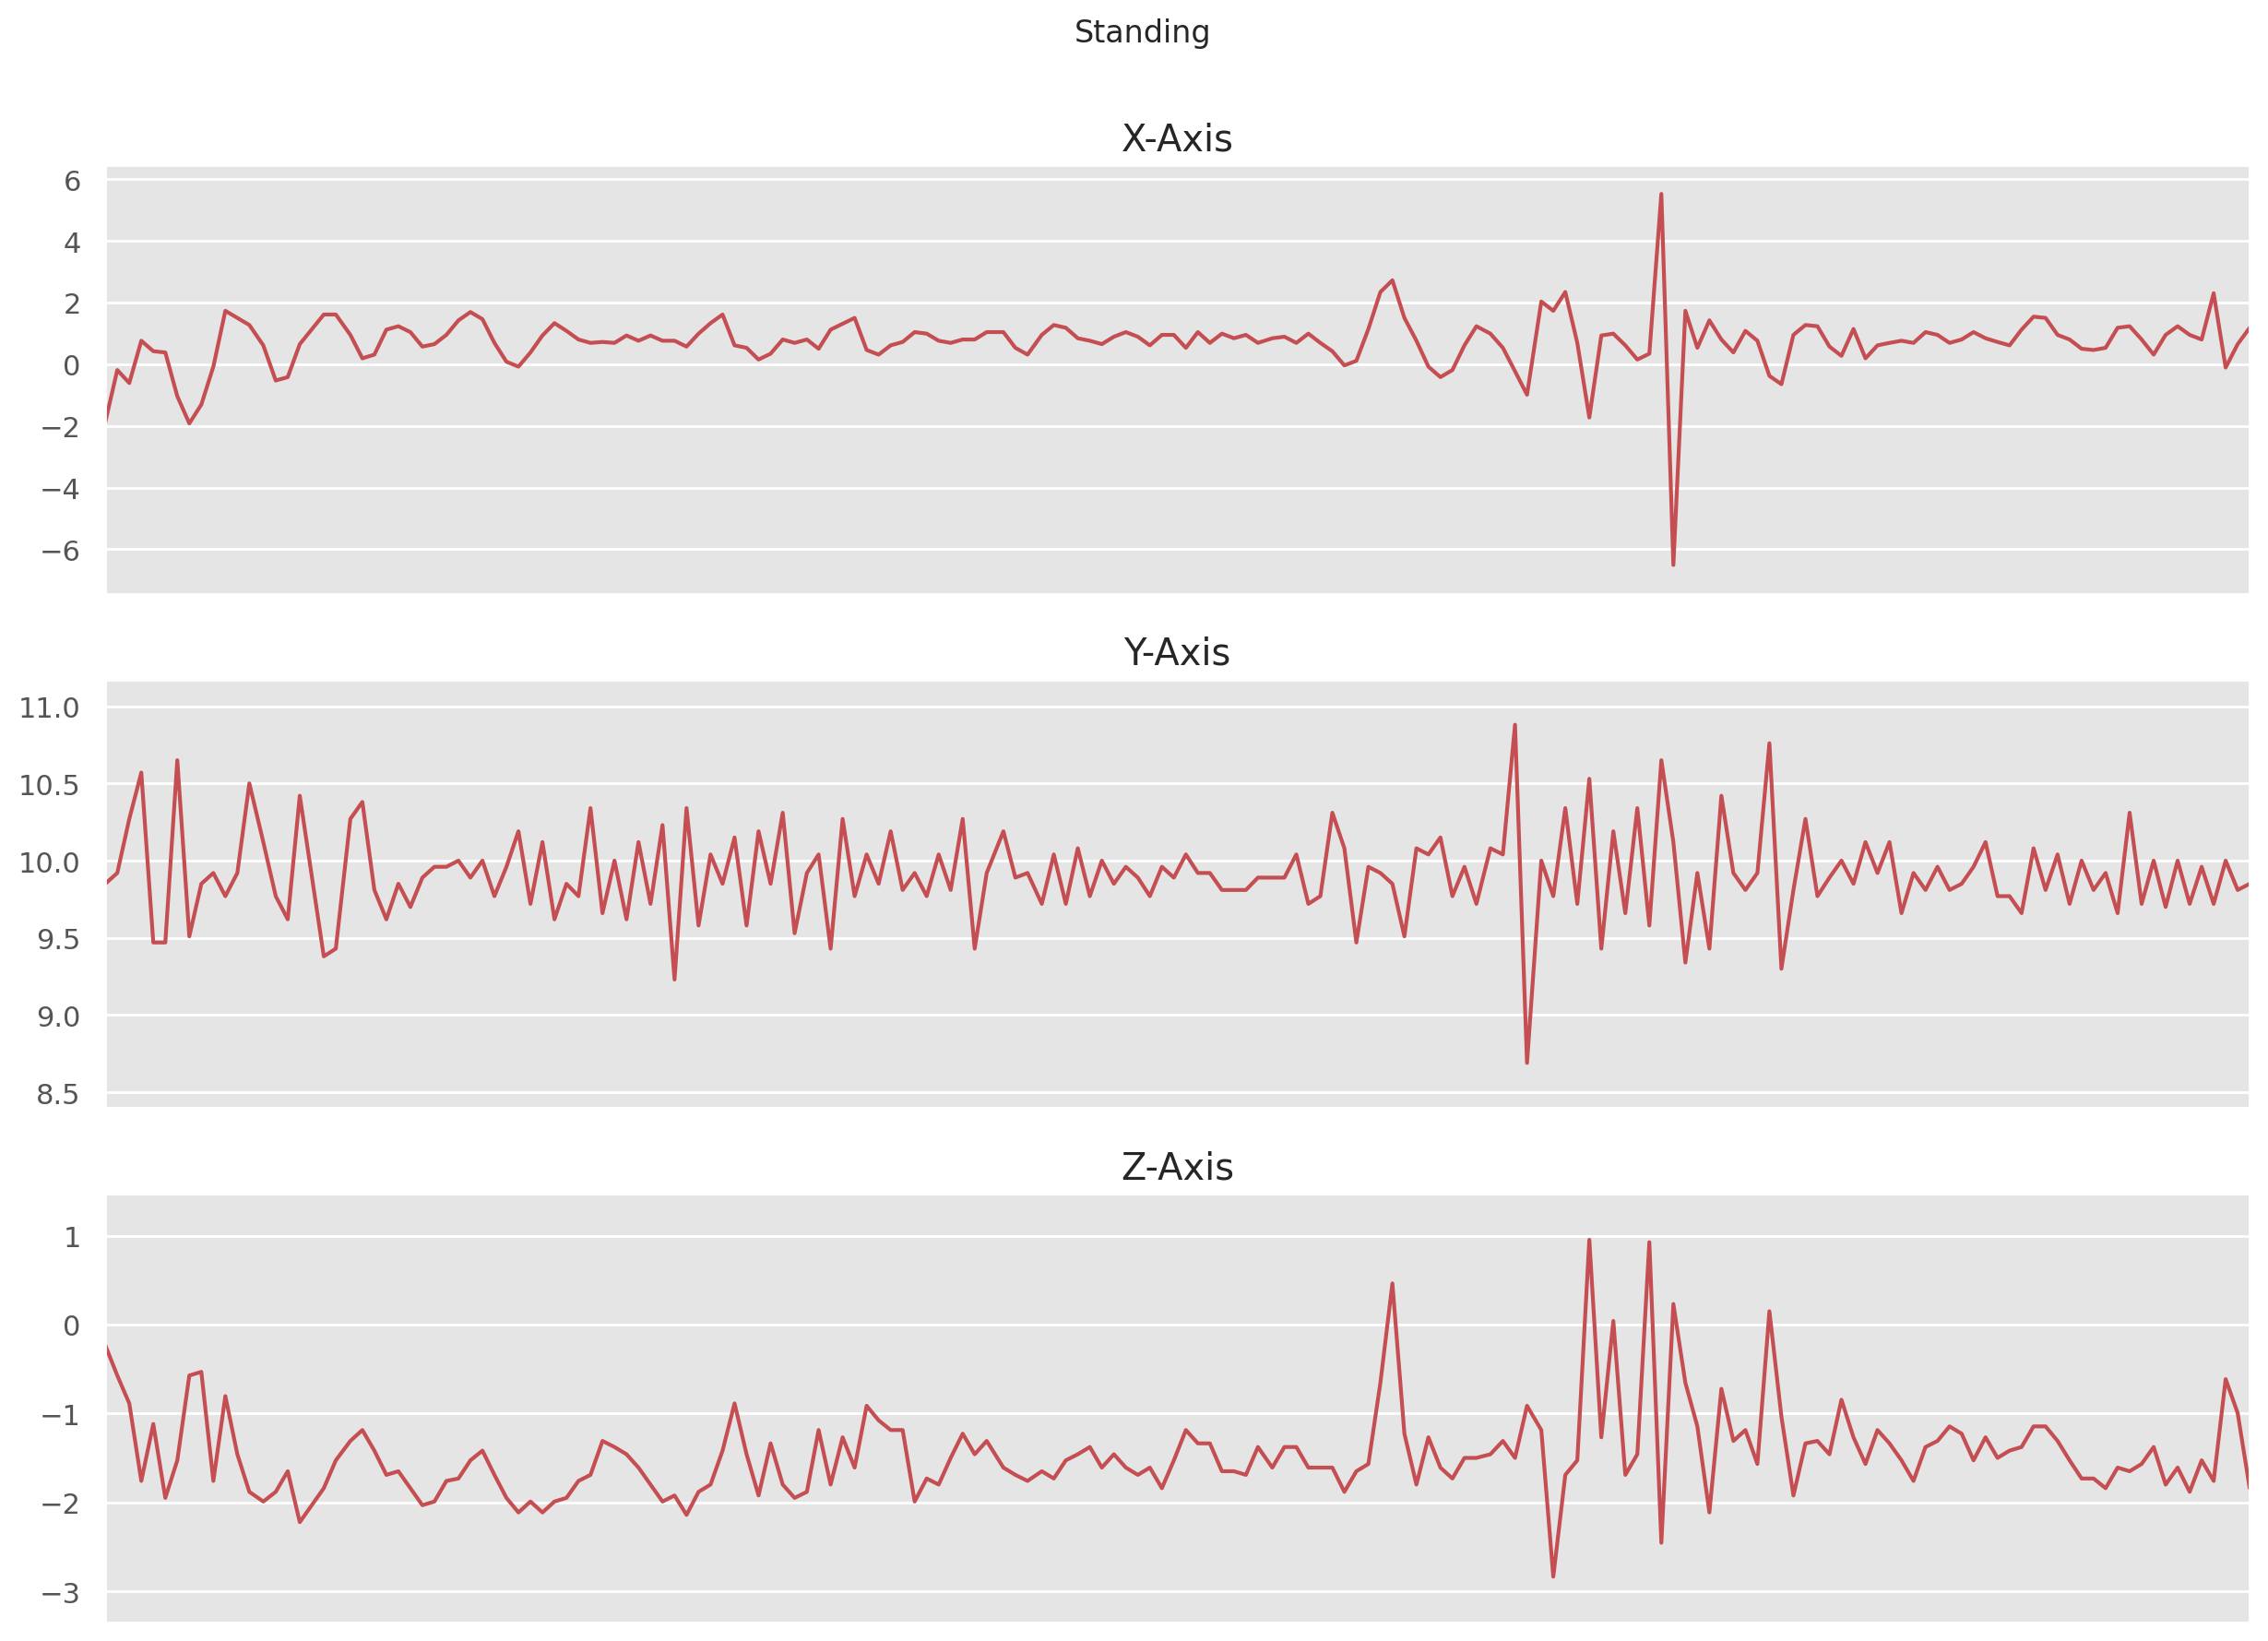

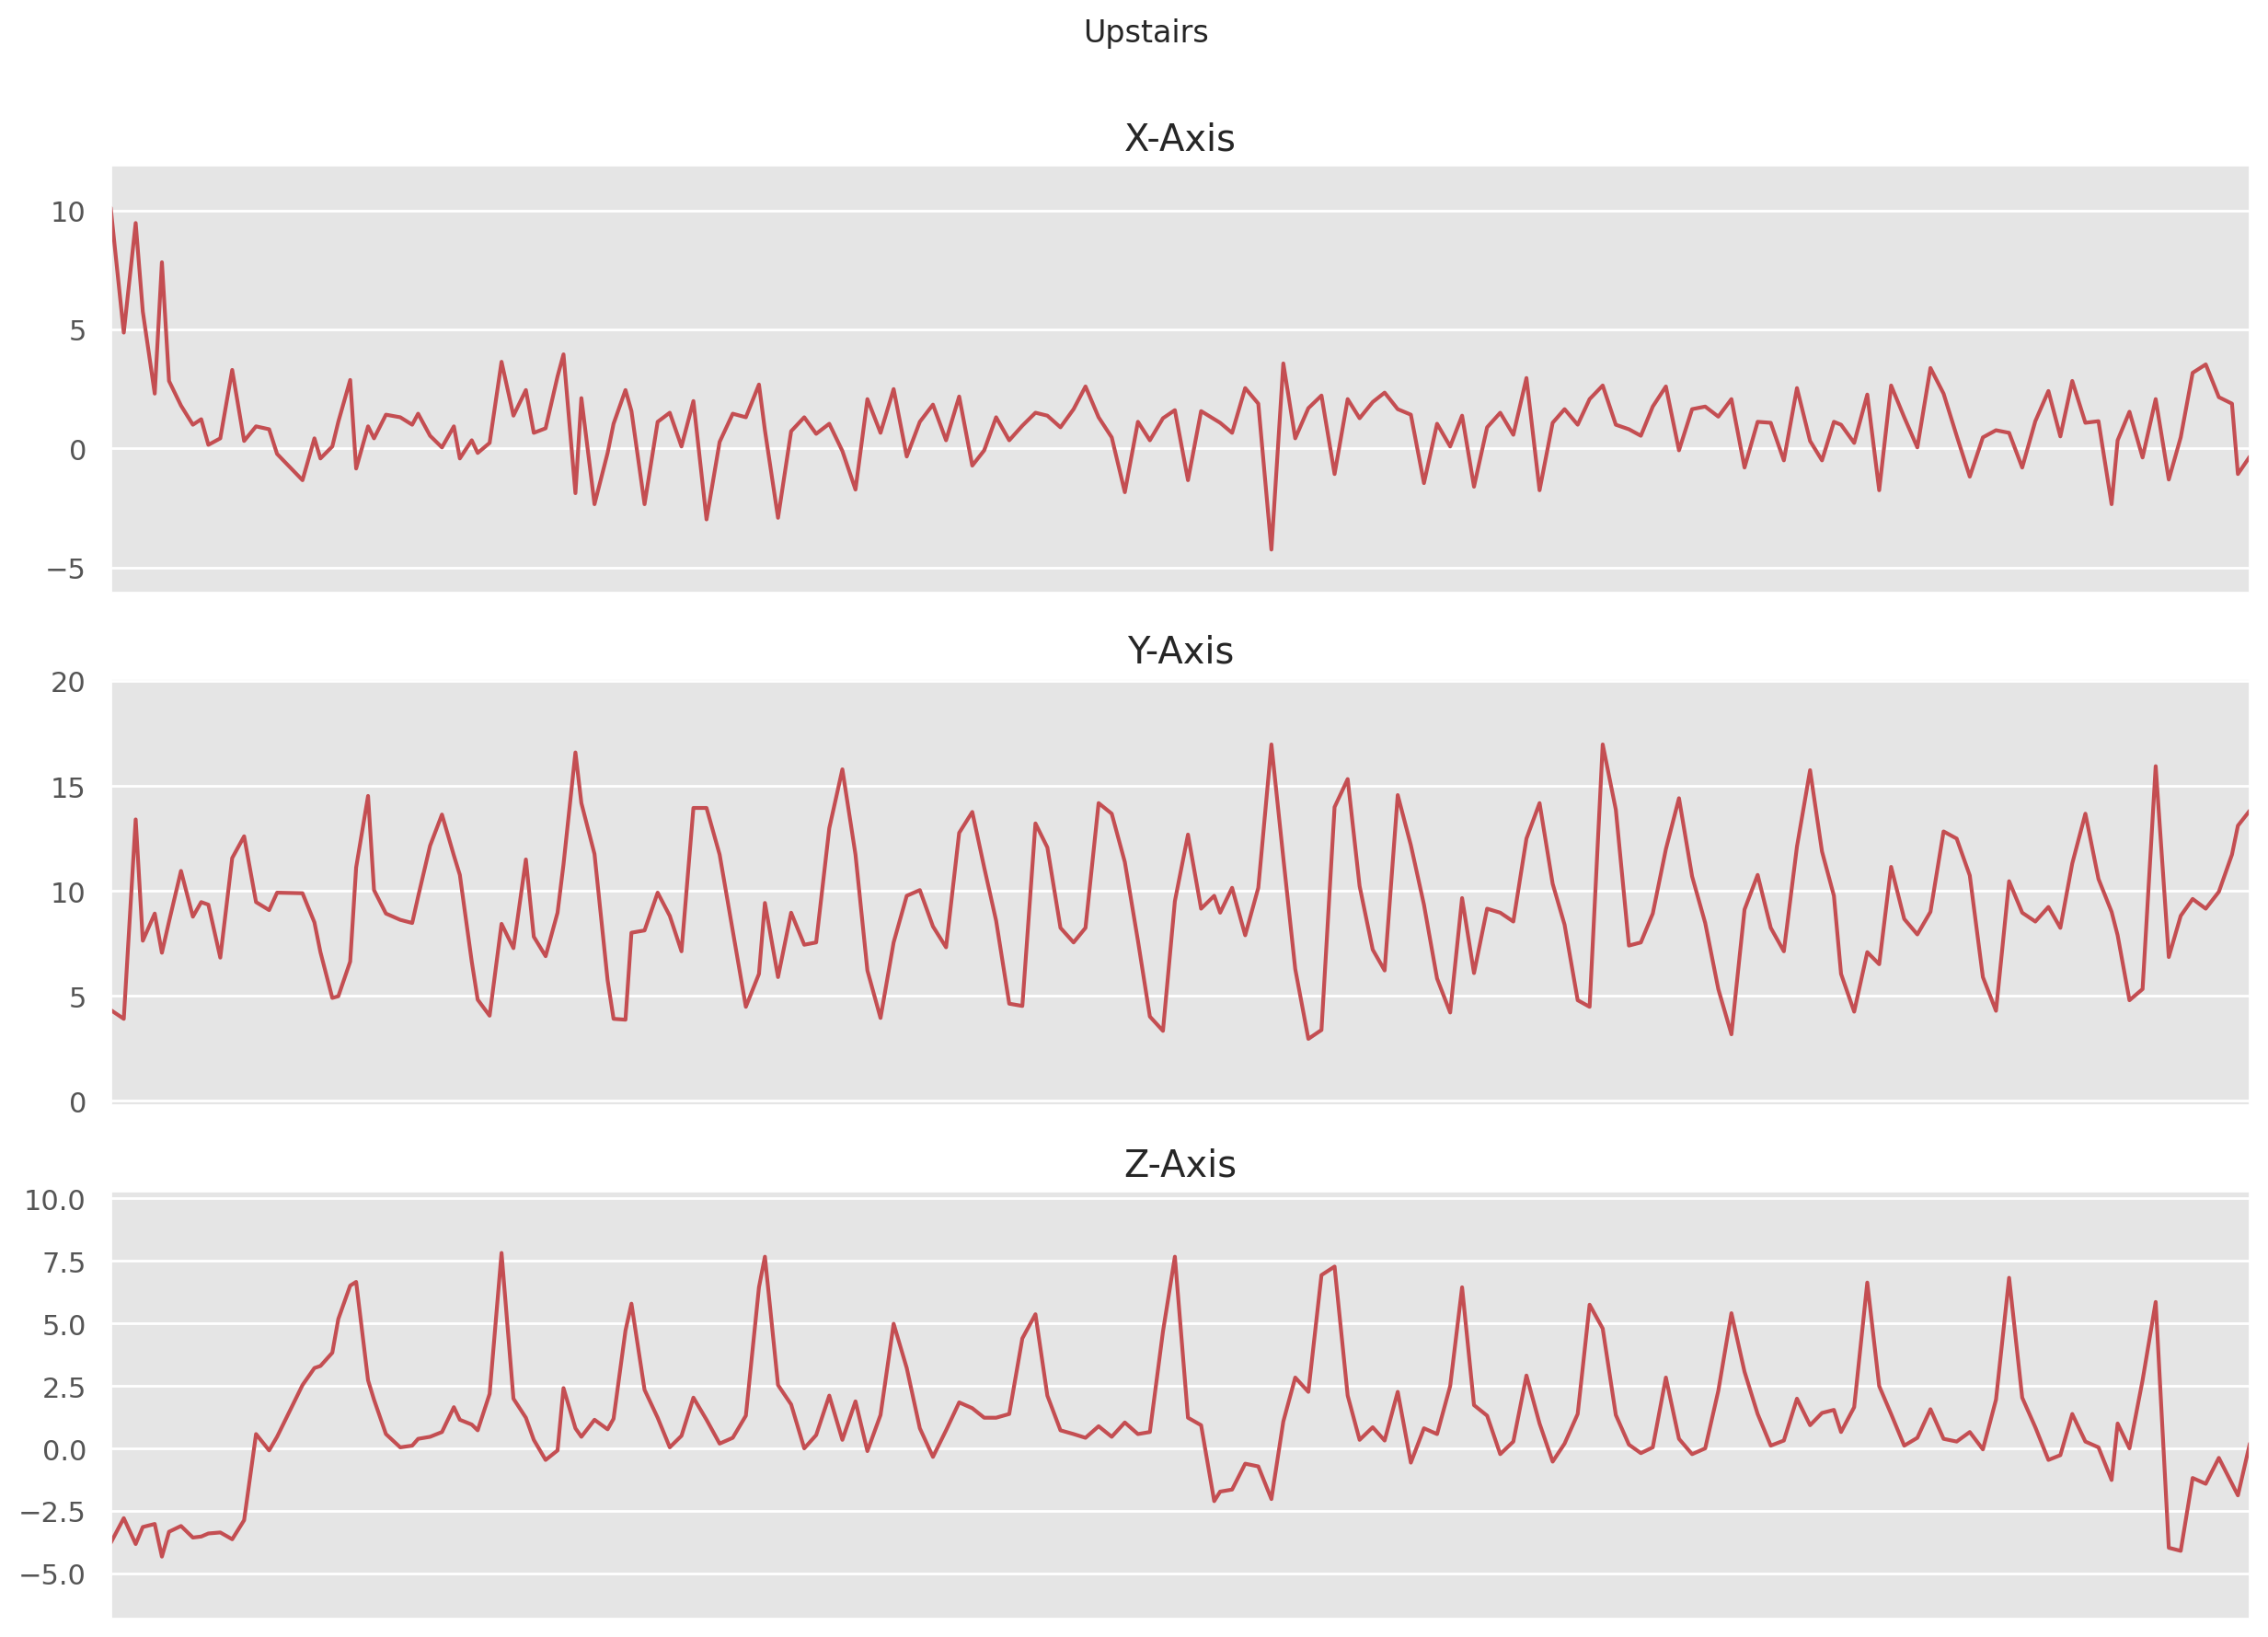

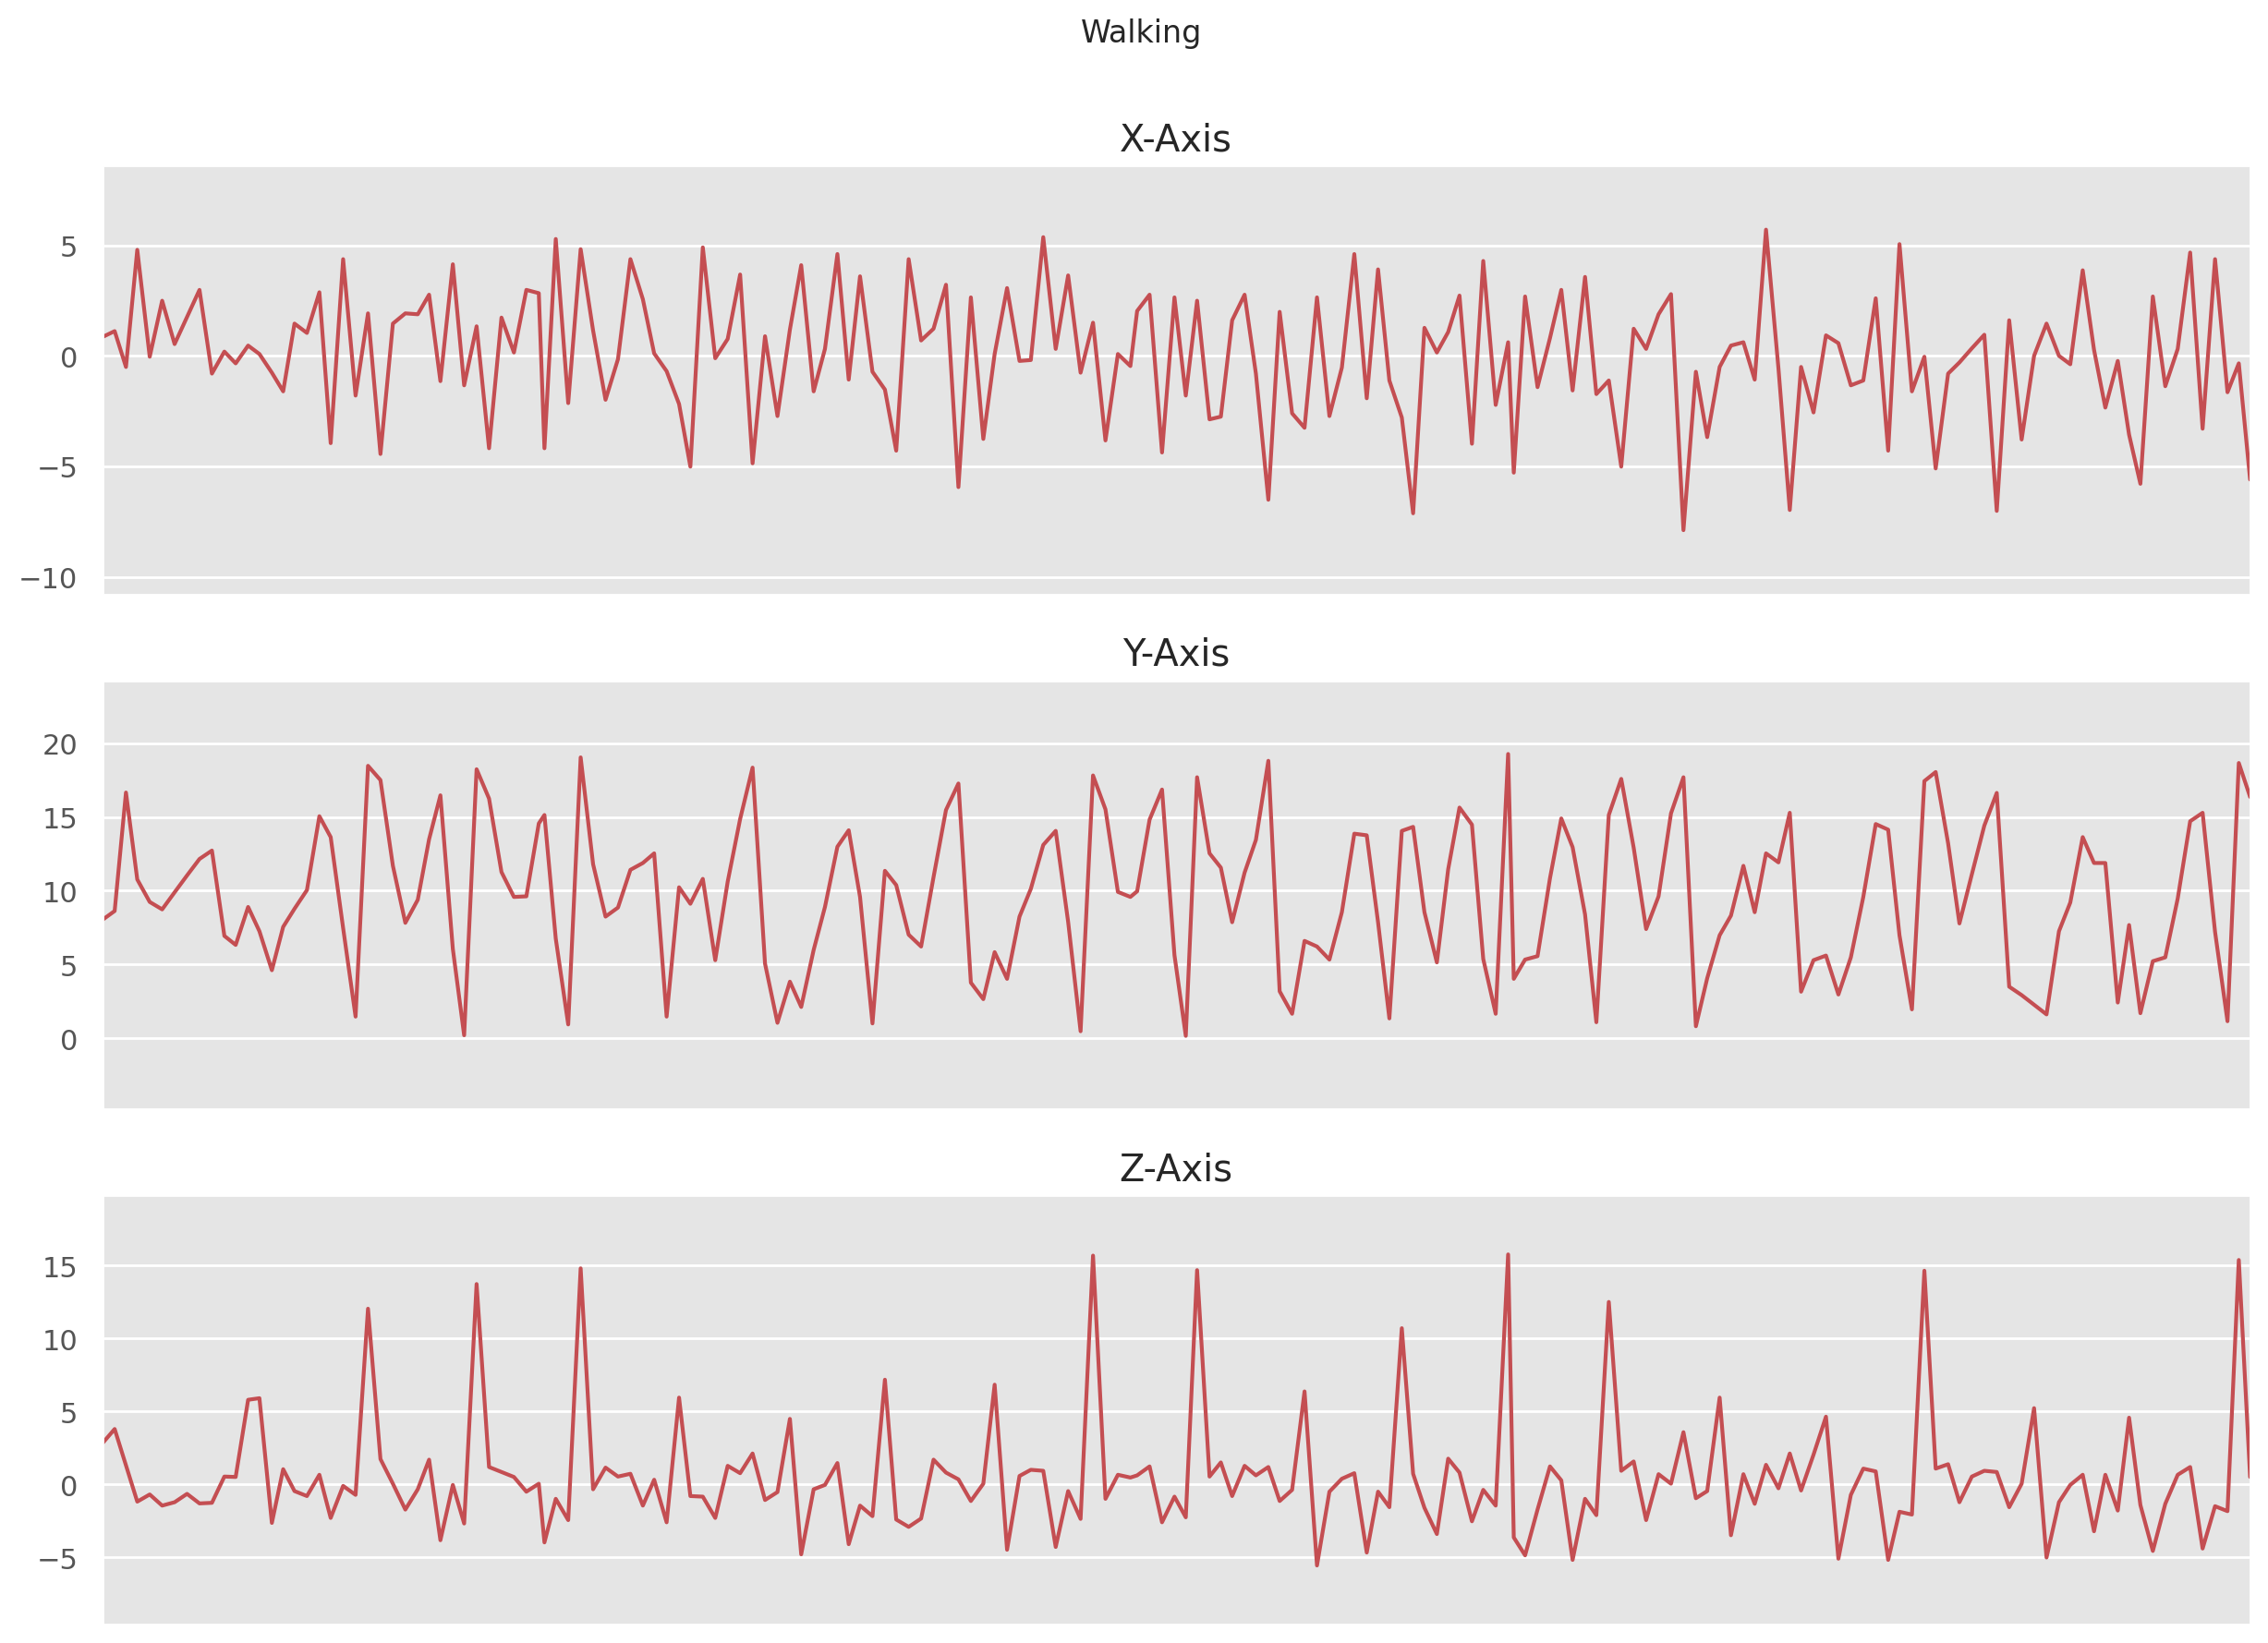

In [17]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [18]:
# lable 벡터의 열의 이름을 정의
LABEL = 'ActivityEncoded'
# LabelEncoder를 이용하여 String을 Integer로 변환
le = preprocessing.LabelEncoder()
# 기존 DataFrame에 새로운 열을 추가
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [19]:
df.ActivityEncoded.tail(10)

1086466    2
1086467    2
1086468    2
1086469    2
1086470    2
1086471    2
1086472    2
1086473    2
1086474    2
1086475    2
Name: ActivityEncoded, dtype: int64

In [20]:
set(df.ActivityEncoded)

{0, 1, 2, 3, 4, 5}

### Train Test 나누기

잘못된 분할 전략 - 각 활동에 대해 적어도 몇 개의 예제 레코드를 가지는 것만으로는 충분하지 않습니다. 예를 들어, 개체 5에 대해 "걷기" 활동의 레코드가 훈련 세트에 3개, 테스트 세트에 1개만 있는 경우와 같은 위험에 처하게 됩니다. 이러한 상황에서는 모델이 이미 훈련 중에 개체 5의 이동 패턴을 보았기 때문에 매우 잘 수행될 것입니다. 항상 DNN의 성능에 대해 비판적으로 생각하십시오. 잘못된 데이터 분할이 원인일 수 있습니다.

개체 ID 1부터 28까지는 모델 훈련에 사용하고, ID가 28보다 큰 개체는 테스트 세트에 사용하겠습니다. 이는 다른 센서 데이터(예: 사물 인터넷)에도 적용됩니다.

In [21]:
# test set과 training set 사이의 차이
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]
df_test
df_train

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.6,9.8,-0.5,5
8490,17,Walking,57870012316000,-0.0,10.2,-0.6,5
8491,17,Walking,57870122301000,-0.2,9.8,-0.7,5
8492,17,Walking,57870222246000,0.1,10.1,-0.5,5
8493,17,Walking,57870332292000,0.1,10.1,-0.6,5
...,...,...,...,...,...,...,...
1086471,19,Sitting,131623331483000,9.0,-1.6,1.7,2
1086472,19,Sitting,131623371431000,9.0,-1.5,1.7,2
1086473,19,Sitting,131623411592000,9.1,-1.4,1.7,2
1086474,19,Sitting,131623491487000,9.0,-1.5,1.7,2


## Training 데이터 정규화

다음으로, 우리는 학습 데이터 내에서 특징들을 정규화해야 합니다. 정규화에는 여러 가지 방법이 있지만, 중요한 것은 나중에 새로운 데이터를 신경망에 입력할 때 동일한 정규화 알고리즘을 사용해야 한다는 점입니다. 그렇지 않으면 예측 결과가 틀릴 것입니다. 정규화와 함께, 저는 세 가지 특징을 소수점 이하 여섯 자리까지 반올림하기로 했습니다. 네트워크의 성능을 더욱 높이기 위해 여기서 최적의 자릿수를 조정해 볼 수 있습니다.

In [22]:
# training 데이터 set에 대해서 특징을 정규화 (0 ~ 1 사이 값)
max_data = []
for axis in ['x-axis','y-axis','z-axis']:
    max_data.append((axis, df_train[axis].max()))
    df_train[axis] = df_train[axis] / df_train[axis].max()
max_data = dict(max_data)
max_data

/tmp/ipykernel_208682/102145446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[axis] = df_train[axis] / df_train[axis].max()


{'x-axis': 19.95, 'y-axis': 20.04, 'z-axis': 19.61}

In [23]:
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

## Data 형태 변형

dataframe내에 포함된 데이터는 아직 신경망에 입력할 준비가 되지 않았습니다. 따라서 데이터를 재구성해야 합니다. 이를 위해 "create_segments_and_labels"라는 또 다른 함수를 만들어봅시다. 이 함수는 데이터프레임과 레이블 이름(처음에 정의한 상수), 그리고 각 레코드의 길이를 입력으로 받습니다. 우리의 경우에는 40 단계로 설정하겠습니다. 20 Hz의 샘플링 속도를 고려하면, 이는 4초의 시간 간격과 같습니다 (계산: 0.05 * 80 = 4). 함수는 데이터를 재구성하는 것 외에도, 특징 (x 가속도, y 가속도, z 가속도)과 레이블 (관련된 활동)을 분리할 것입니다.

In [24]:
print(TIME_PERIODS)
print(STEP_DISTANCE)
print(LABEL)

80
40
ActivityEncoded


In [25]:
from scipy import stats
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z 가속도
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # 이 segment내에서 가장 자주 사용된 label 구하기
        # print('i: ', i, 'time_steps :', time_steps, 'df[label_name][i: i + time_steps] :', df[label_name][i: i + time_steps])
        
        mode, count = stats.mode(df[label_name][i: i + time_steps])
        # print('stats.mode', mode)
        label = LABELS[int(mode)]
        # label = mode_result[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # 세그먼트를 더 나은 형태로
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [26]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

지금까지 x_train과 y_train 모두에 20,868개의 레코드가 있어야 합니다. x_train의 20,868개 레코드 각각은 80x3의 크기를 가진 2차원 행렬입니다.

In [27]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20575, 80, 3)
20575 training samples
y_train shape:  (20575,)


In [28]:
#x_train[0]

deep 신경망을 구성하기 위해 다음 차원을 저장해야 합니다. :
-  time periods 개수 : 한 레코드 내의 시간 기간 수입니다. (2초 간격을 원하므로, 이 값은 40입니다)
-  sensors 개수 : x, y, z 축의 가속도만 사용하므로 3입니다.
-  클래스 수 : 신경망의 출력층의 노드 수입니다. 신경망이 활동 유형을 예측하도록 하려면, 이전에 사용한 인코더의 클래스 수를 사용합니다.

In [29]:
# Set input & output 차원
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


우리가 네트워크에 입력하고 싶은 데이터는 2차원 (80x3)입니다. 불행히도, Keras와 CoreML을 함께 사용하면 다차원 입력 데이터를 처리할 수 없습니다. 따라서 우리는 신경망의 입력 계층에 입력할 수 있도록 데이터를 'flatten'하게 만들어야 합니다. 80x3 형태의 행렬을 입력하는 대신, 240개의 값으로 구성된 목록을 입력할 것입니다.

In [30]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20575, 240)
input_shape: 240


 계속 진행하기 전에, 모든 특징 데이터(x_train)와 레이블 데이터(y_train)를 Keras에서 인식할 수 있는 데이터 형식으로 변환해야 합니다.

In [31]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# ㄷencoded labels을 float32로 변환하기
y_train = y_train_encoded.astype('float32')
y_train = y_train.astype('float32')

우리는 데이터 준비를 거의 마쳤습니다. 마지막 단계로 레이블에 대한 one-hot encoding을 수행해야 합니다. 이 줄은 한 번만 실행하세요.

In [32]:
from tensorflow.keras.utils import to_categorical


y_train_hot = to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20575, 6)


## Keras로 1D CNN Model 생성

이제까지 많은 작업들을 완료했습니다. 데이터는 Keras가 처리할 수 있는 형식으로 준비되어 있습니다. 저는 각각 100개의 완전히 연결된 노드로 구성된 3개의 은닉층을 가진 신경망을 생성하기로 결정했습니다.

중요한 노드: 기억하시겠지만, 우리는 입력 데이터를 80x3 매트릭스에서 길이가 240인 벡터로 재구성했습니다. 이를 되돌리기 위해, 신경망의 첫 번째 레이어는 데이터를 "이전" 형식으로 재구성할 것입니다. 마지막 두 레이어는 다시 데이터를 평면화한 다음 각 클래스에 대한 확률을 계산하기 위해 소프트맥스 활성화 함수를 실행할 것입니다. 우리는 우리의 경우에 6개의 클래스(내려가기, 조깅, 앉기, 서기, 올라가기, 걷기)와 작업하고 있음을 기억하십시오.

In [33]:
# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

/home/jeyong/projects/my_data_env/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jeyong/projects/my_data_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724600569.361120  208682 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 00:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 80, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 71, 100)        │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 62, 100)        │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 160)        │       160,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 160)         │       256,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 160)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,486 (1.99 MB)

 Trainable params: 520,486 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

None


## Keras에서 DNN Modle 맞추기

다음으로, 이전에 준비한 학습 데이터로 모델을 학습시킬 것입니다. 학습 정확도에 대한 조기 중단 콜백 모니터를 정의할 것입니다: 학습이 연속적인 두 에포크 동안 개선되지 않으면, 최상의 모델로 학습이 중지됩니다. 학습에 사용된 하이퍼파라미터는 매우 간단합니다: 배치 크기를 400 레코드로 사용하고 모델을 50 에포크 동안 학습시킬 것입니다. 모델 학습을 위해, 학습 데이터와 검증 데이터를 분리하기 위해 80:20 분할을 사용할 것입니다. 매우 간단합니다. 따라서 모델을 학습시켜 봅시다. 다른 하이퍼파라미터에 대한 좋은 설명이 있습니다. [참고](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

In [38]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_CNN/best_model.{epoch:02d}-{val_loss:.2f}.keras',
        monitor='val_loss', save_best_only=True),
    # keras.callbacks.EarlyStopping(monitor='acc', patience=0)
]
BATCH_SIZE = 400
EPOCHS = 50
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0.8258 - val_loss: 1.3749
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9954 - loss: 0.0159 - val_accuracy: 0.8032 - val_loss: 1.2933
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9943 - loss: 0.0209 - val_accuracy: 0.8433 - val_loss: 1.1064
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9954 - loss: 0.0146 - val_accuracy: 0.8469 - val_loss: 1.1777
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9923 - loss: 0.0259 - val_accuracy: 0.8032 - val_loss: 1.3732
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9933 - loss: 0.0199 - val_accuracy: 0.8464 - val_loss: 1.1140
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9938 - loss: 0.0187 - val_accuracy: 0.8403 - val_loss: 1.1553
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9944 - loss: 0.0204 - val_accuracy: 0.8262 - v

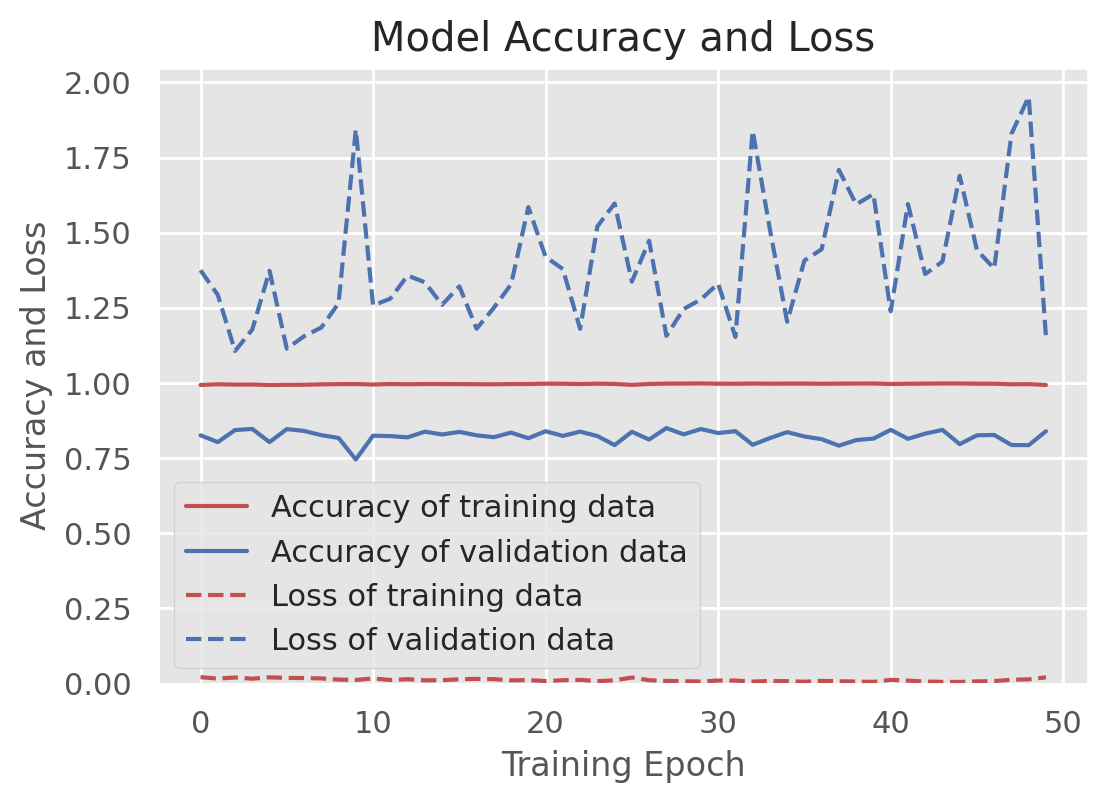

643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      1860
         1.0       0.98      0.97      0.98      6426
         2.0       0.99      1.00      0.99      1050
         3.0       0.99      1.00      1.00       835
         4.0       0.92      0.92      0.92      2344
         5.0       0.98      0.98      0.98      8060

    accuracy                           0.97     20575
   macro avg       0.96      0.96      0.96     20575
weighted avg       0.97      0.97      0.97     20575



In [39]:
history = model_m.history
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))


## Test 데이터 확인

이 모델을 계속 사용하여 이전에 따로 보관해둔 테스트 데이터에 대한 성능을 확인해보겠습니다. 저희의 경우에는 모델이 아직 보지 못한 6명의 사용자의 행동에 대한 성능을 점검할 것입니다.

In [40]:
from sklearn.preprocessing import LabelEncoder
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test = y_test_encoded.astype('float32')

y_test = to_categorical(y_test, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)
print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

/tmp/ipykernel_208682/783495184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
/tmp/ipykernel_208682/783495184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
/tmp/ipykernel_208682/783495184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8787 - loss: 0.9634

Accuracy on test data: 0.88

Loss on test data: 0.76


테스트 데이터에 대한 정확도는 88%입니다. 이는 우리 모델이 아직 보지 못한 사람들에게도 잘 일반화된다는 것을 의미합니다. 우리 모델이 레이블을 잘못 예측한 곳을 살펴봅시다.

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


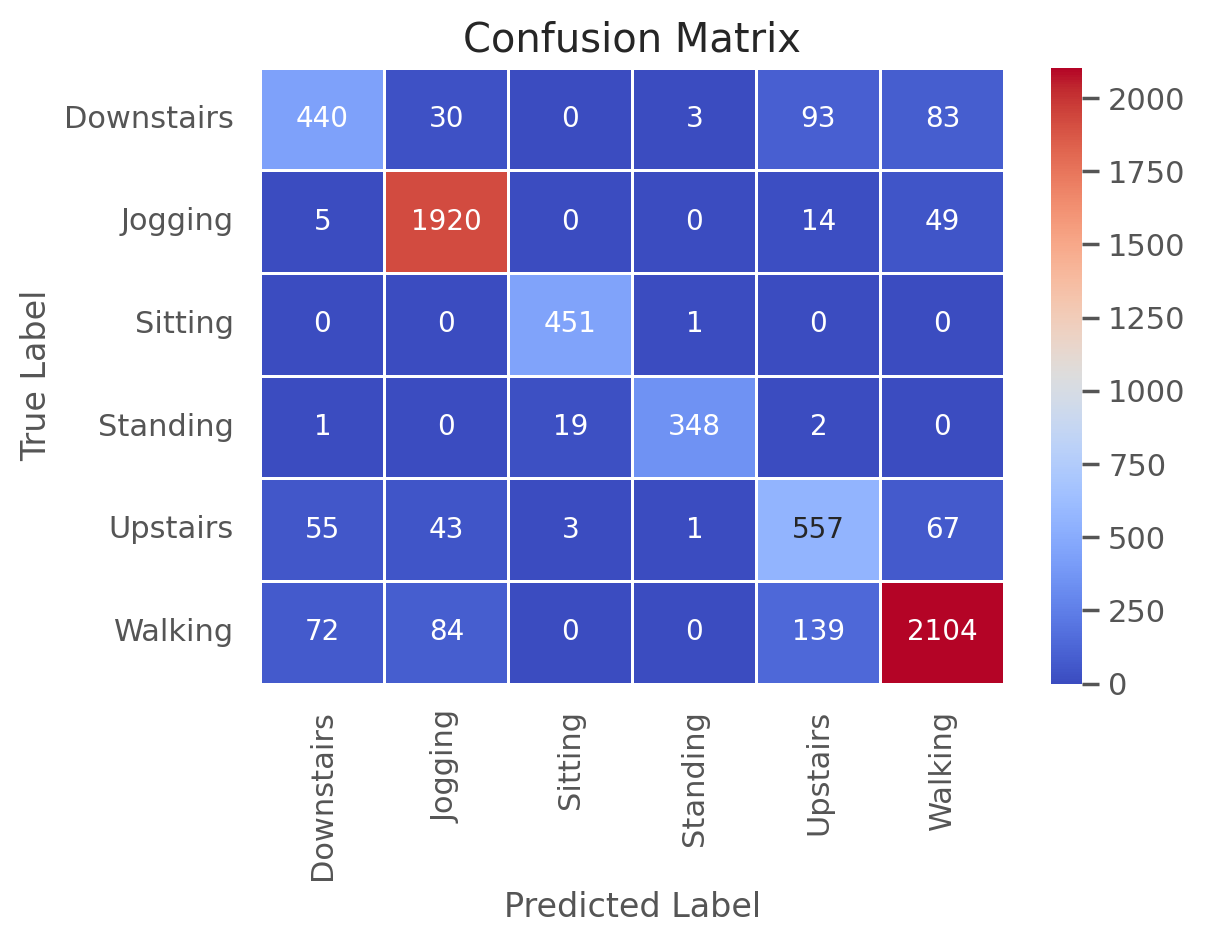

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       649
           1       0.92      0.97      0.94      1988
           2       0.95      1.00      0.98       452
           3       0.99      0.94      0.96       370
           4       0.69      0.77      0.73       726
           5       0.91      0.88      0.89      2399

    accuracy                           0.88      6584
   macro avg       0.87      0.87      0.87      6584
weighted avg       0.88      0.88      0.88      6584



In [41]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# 테스트 추론에서 가장 높은 확률을 가진 class를 선택
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

보다시피, 모델의 정확도는 조깅(1), 앉기(2), 서기(3) 및 걷기(5)를 예측하는 데 있어서 좋습니다. 이 모델은 오르내리기 활동을 명확하게 식별하는 데 문제가 있습니다.

물론 모델을 개선할 수 있는 큰 잠재력이 있습니다. 예를 들어, 컨볼루션 신경망(CNN)이나 장단기 메모리(LSTM)와 같은 더 고급 신경망을 사용할 수 있습니다.

## 추론 

CoreML 모델을 사용하기 전에, export가 성공적으로 이루어졌는지, 그리고 Keras 모델과 CoreML 모델 모두 동일한 임의의 데이터 세트를 입력받을 때 동일한 예측을 제공하는지 확인합시다.

In [42]:
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print('\nPrediction:\t',le.inverse_transform(keras_prediction)[0])
print('\nTruth:\t\t',LABELS[np.argmax(y_test[1])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Prediction:	 Jogging

Truth:		 Jogging
